<a href="https://colab.research.google.com/github/BamdadBooyeh/NLP/blob/main/NLP_emotion_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[TRAIN] Label Counts:
         0: 4666
         1: 5362
         2: 1304
         3: 2159
         4: 1937
         5: 572

[VALIDATION] Label Counts:
         0: 550
         1: 704
         2: 178
         3: 275
         4: 212
         5: 81

[TEST] Label Counts:
         0: 581
         1: 695
         2: 159
         3: 275
         4: 224
         5: 66


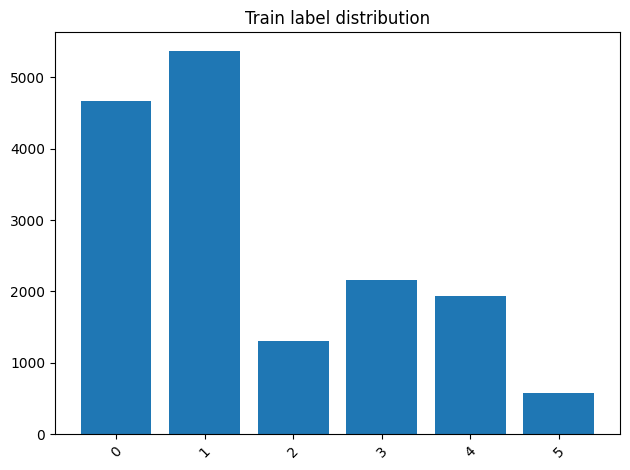

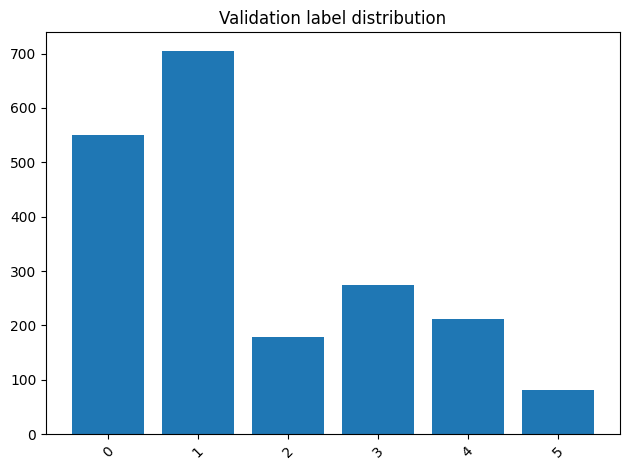

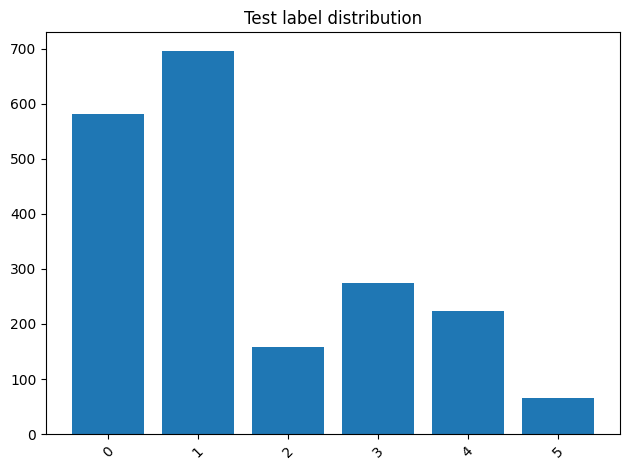


Chance accuracy: 0.17
Majority class baseline accuracy: 0.34 (1)

Train text length - Min: 2, Max: 66, Mean: 19.17, Std: 10.99

Validation text length - Min: 2, Max: 61, Mean: 18.87, Std: 10.81

Test text length - Min: 3, Max: 61, Mean: 19.15, Std: 11.01

Vocabulary size: 15214

✅ Data preparation complete. Loaders are ready!


In [3]:
import torch
from datasets import load_dataset
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import pandas as pd
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader # Import DataLoader and TensorDataset here
import torch.nn as nn

splits = {'train': 'split/train-00000-of-00001.parquet', 'validation': 'split/validation-00000-of-00001.parquet', 'test': 'split/test-00000-of-00001.parquet'}
dataset = {
    split: pd.read_parquet(f"hf://datasets/dair-ai/emotion/{path}")
    for split, path in splits.items()
}
label_names = sorted(dataset["train"]["label"].unique())
label_names = [str(lbl) for lbl in label_names]  # In case labels are ints

def label_stats(split):
    # Ensure dataset[split] is a DataFrame here
    if not isinstance(dataset[split], pd.DataFrame):
        print(f"Warning: dataset['{split}'] is not a DataFrame when calling label_stats.")
        # You might need to handle this case if label_stats is called after tensor conversion
        # For this fix, we assume label_stats is called before the conversion.
        return [], Counter() # Return empty results if not a DataFrame

    labels = dataset[split]["label"].tolist()
    counts = Counter(labels)
    print(f"\n[{split.upper()}] Label Counts:")
    for label, count in sorted(counts.items()):
        # Ensure label is within the bounds of label_names
        if label < len(label_names):
            print(f"{label_names[label]:>10}: {count}")
        else:
            print(f"Unknown label ({label}): {count}")
    return labels, counts

# Re-define splits as a list after the dictionary definition
splits = ['train', 'validation', 'test']
split_labels = {}
for split in splits:
    split_labels[split], counts = label_stats(split)

# Plot distribution
for split in splits:
    plt.figure()
    labels = split_labels[split]
    counts = Counter(labels)
    # Use label_names as x-axis labels and counts corresponding to label_names order
    plt.bar(label_names, [counts.get(i, 0) for i in range(len(label_names))]) # Use .get(i, 0) to handle potential missing labels
    plt.title(f"{split.capitalize()} label distribution")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Chance accuracy (random guess)
total_train = len(split_labels['train'])
most_common_class = Counter(split_labels['train']).most_common(1)[0]
chance_accuracy = 1 / len(label_names)
majority_accuracy = most_common_class[1] / total_train
print(f"\nChance accuracy: {chance_accuracy:.2f}")
# Ensure index is within bounds
if most_common_class[0] < len(label_names):
    print(f"Majority class baseline accuracy: {majority_accuracy:.2f} ({label_names[most_common_class[0]]})")
else:
     print(f"Majority class baseline accuracy: {majority_accuracy:.2f} (Unknown label)")


# STEP 2: Tokenization
def tokenize(text):
    return text.lower().split()

# Apply tokenization while dataset is still a DataFrame
for split in splits:
    # Ensure dataset[split] is a DataFrame before applying .apply()
    if isinstance(dataset[split], pd.DataFrame):
        dataset[split]["tokens"] = dataset[split]["text"].apply(tokenize)
    else:
        print(f"Warning: dataset['{split}'] is not a DataFrame during tokenization.")

# Text length stats - **MOVED HERE**
# Calculate lengths while dataset[split] is still a DataFrame with a 'tokens' column
lengths = {split: [len(ex['tokens']) for _, ex in dataset[split].iterrows()] for split in splits if isinstance(dataset[split], pd.DataFrame)} # Iterate over rows if it's a DataFrame
for split in splits:
    if split in lengths: # Check if length data was collected for this split
        lens = lengths[split]
        print(f"\n{split.capitalize()} text length - Min: {min(lens)}, Max: {max(lens)}, Mean: {np.mean(lens):.2f}, Std: {np.std(lens):.2f}")
    else:
        print(f"\nCould not calculate text length stats for {split.capitalize()} (not a DataFrame).")


# STEP 3: Build vocabulary
PAD_TOKEN = "<PAD>"
OOV_TOKEN = "<OOV>"

# Flatten all tokens in train split
# Ensure dataset['train'] is a DataFrame before accessing 'tokens'
all_tokens = []
if isinstance(dataset['train'], pd.DataFrame):
    all_tokens = [token for example in dataset['train']['tokens'] for token in example]
else:
    print("\nWarning: dataset['train'] is not a DataFrame. Cannot build vocabulary from tokens.")

vocab = {PAD_TOKEN: 0, OOV_TOKEN: 1}
if all_tokens: # Only build vocab if tokens were collected
    for token in set(all_tokens):
        vocab[token] = len(vocab)

# Reverse vocab
id2word = {idx: word for word, idx in vocab.items()}

print(f"\nVocabulary size: {len(vocab)}")

# STEP 4: Encode texts with OOV handling
def encode_tokens(tokens, vocab):
    return [vocab.get(token, vocab[OOV_TOKEN]) for token in tokens]

for split in splits:
    # Ensure dataset[split] is a DataFrame before applying .apply()
    if isinstance(dataset[split], pd.DataFrame):
        dataset[split]["input_ids"] = dataset[split]["tokens"].apply(lambda tokens: encode_tokens(tokens, vocab))
    else:
         print(f"Warning: dataset['{split}'] is not a DataFrame during encoding.")


# STEP 5: Padding and tensor conversion
# Use MAX_LEN calculated from the 'lengths' dictionary
# Check if 'lengths' was successfully populated
if 'train' in lengths:
    MAX_LEN = int(np.percentile(lengths['train'], 95))
else:
    MAX_LEN = 50 # Fallback value if lengths could not be calculated
    print(f"Warning: Could not determine MAX_LEN from lengths. Using default: {MAX_LEN}")


def pad_sequence(seq, max_len, pad_val):
    # Ensure seq is a list
    if not isinstance(seq, list):
        print(f"Warning: pad_sequence received non-list input: {type(seq)}")
        return [] # Return empty list if input is not list
    return seq[:max_len] + [pad_val] * max(0, max_len - len(seq))

# This is where the dataset is converted from DataFrame to dictionary of tensors
for split in splits:
    inputs = []
    labels = []
    # Ensure dataset[split] is a DataFrame with necessary columns before iteration
    if isinstance(dataset[split], pd.DataFrame) and 'input_ids' in dataset[split].columns and 'label' in dataset[split].columns:
        for index, example in dataset[split].iterrows(): # Iterate over DataFrame rows
            # Ensure 'input_ids' is a list before padding
            input_ids_list = example['input_ids']
            if not isinstance(input_ids_list, list):
                 print(f"Warning: input_ids for example in {split} is not a list: {type(input_ids_list)}")
                 input_ids_list = [] # Use empty list if not a list

            padded = pad_sequence(input_ids_list, MAX_LEN, vocab.get(PAD_TOKEN, -1)) # Use .get() for PAD_TOKEN to be safe, fallback to -1
            inputs.append(padded)
            labels.append(example['label'])

        inputs_tensor = torch.tensor(inputs)
        labels_tensor = torch.tensor(labels)
        dataset[split] = {'inputs': inputs_tensor, 'labels': labels_tensor}
    else:
        print(f"Warning: dataset['{split}'] is not a DataFrame with 'input_ids' and 'label' columns. Skipping tensor conversion for this split.")
        # If conversion failed, ensure dataset[split] is not expected to be tensors later
        # Depending on the rest of the pipeline, you might want to remove this split from 'loaders' later

# Create DataLoaders
batch_size = 32
loaders = {}
for split in splits:
    # Check if dataset[split] has the expected structure (dictionary with 'inputs' and 'labels' tensors)
    if isinstance(dataset[split], dict) and 'inputs' in dataset[split] and 'labels' in dataset[split] and isinstance(dataset[split]['inputs'], torch.Tensor) and isinstance(dataset[split]['labels'], torch.Tensor):
        tensor_dataset = TensorDataset(dataset[split]['inputs'], dataset[split]['labels'])
        shuffle = True if split == 'train' else False
        loaders[split] = DataLoader(tensor_dataset, batch_size=batch_size, shuffle=shuffle)
    else:
        print(f"Warning: Could not create DataLoader for {split}. Dataset structure not as expected.")


print("\n✅ Data preparation complete. Loaders are ready!")

In [4]:


class EmotionClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, pad_idx):
        super(EmotionClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.fc1 = nn.Linear(embed_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, input_ids):
        # input_ids: (batch_size, seq_len)
        embedded = self.embedding(input_ids)  # (batch_size, seq_len, embed_dim)

        # Mean pooling (ignore PAD tokens)
        mask = (input_ids != self.embedding.padding_idx).unsqueeze(-1).float()  # (batch_size, seq_len, 1)
        summed = torch.sum(embedded * mask, dim=1)  # (batch_size, embed_dim)
        counts = torch.clamp(mask.sum(dim=1), min=1e-9)  # Avoid division by zero
        pooled = summed / counts  # (batch_size, embed_dim)

        x = F.relu(self.fc1(pooled))
        out = self.fc2(x)
        return out

In [5]:
import torch.optim as optim

def train_model(model, loaders, num_epochs=10, lr=1e-3, device='cpu'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_loss = 0
        for inputs, labels in loaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(loaders['train'])

        # Validation
        model.eval()
        val_loss = 0
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in loaders['validation']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        avg_val_loss = val_loss / len(loaders['validation'])
        val_accuracy = correct / total

        # Save
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

    return train_losses, val_losses, val_accuracies

In [6]:
import matplotlib.pyplot as plt

def plot_training(train_losses, val_losses, val_accuracies):
    epochs = range(1, len(train_losses)+1)

    plt.figure(figsize=(12,4))

    # Loss plot
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    # Accuracy plot
    plt.subplot(1,2,2)
    plt.plot(epochs, val_accuracies, label="Val Accuracy", color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch 1/10 | Train Loss: 1.5025 | Val Loss: 1.3714 | Val Acc: 0.4815
Epoch 2/10 | Train Loss: 1.0739 | Val Loss: 0.9699 | Val Acc: 0.6540
Epoch 3/10 | Train Loss: 0.6555 | Val Loss: 0.7633 | Val Acc: 0.7310
Epoch 4/10 | Train Loss: 0.4173 | Val Loss: 0.6367 | Val Acc: 0.7825
Epoch 5/10 | Train Loss: 0.2781 | Val Loss: 0.6278 | Val Acc: 0.7935
Epoch 6/10 | Train Loss: 0.1943 | Val Loss: 0.5996 | Val Acc: 0.8145
Epoch 7/10 | Train Loss: 0.1374 | Val Loss: 0.6134 | Val Acc: 0.8190
Epoch 8/10 | Train Loss: 0.1001 | Val Loss: 0.6467 | Val Acc: 0.8140
Epoch 9/10 | Train Loss: 0.0739 | Val Loss: 0.6776 | Val Acc: 0.8200
Epoch 10/10 | Train Loss: 0.0541 | Val Loss: 0.7162 | Val Acc: 0.8215


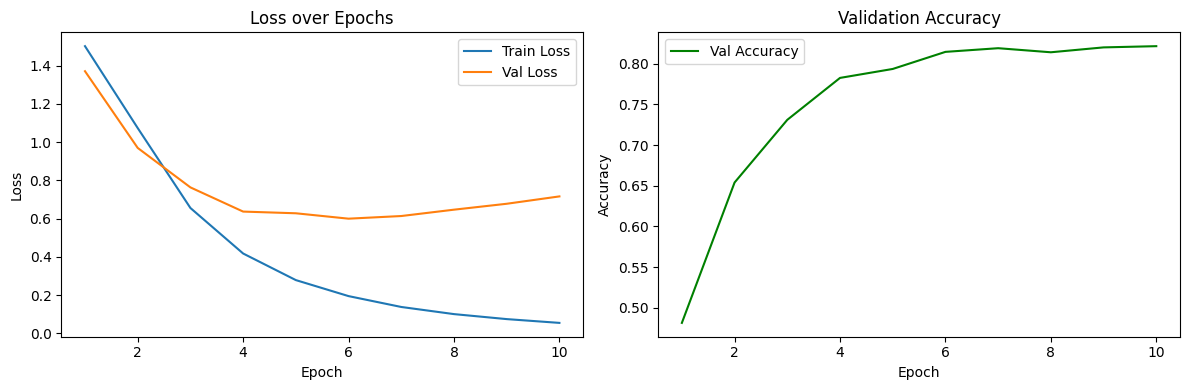

In [7]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model
vocab_size = len(vocab)
embed_dim = 100
num_classes = len(label_names)
pad_idx = vocab["<PAD>"]

# Train
model = EmotionClassifier(vocab_size, embed_dim, num_classes, pad_idx)
train_losses, val_losses, val_accuracies = train_model(model, loaders, num_epochs=10, lr=1e-3, device=device)

# Plot
plot_training(train_losses, val_losses, val_accuracies)

In [9]:
def evaluate_on_test(model, loader, device='cpu'):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    test_acc = correct / total
    print(f"\n🧪 Final Test Accuracy: {test_acc:.4f}")
    return test_acc

evaluate_on_test(model, loaders['test'], device=device)


🧪 Final Test Accuracy: 0.7995


0.7995